In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
%pip install scikit-opt
from sko.PSO import PSO
import numpy as np
from scipy.fft import dct, idct
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['font.weight'] = 'bold' 

Note: you may need to restart the kernel to use updated packages.


# Rosenbrock function

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ----------- 2D NDCT Basis + Fit + Predict -----------
def ndct2_basis(x, y, Kx, Ky):
    """Construct the 2D Non-Discrete Cosine Transform (NDCT) basis matrix."""
    x = np.asarray(x).reshape(-1)
    y = np.asarray(y).reshape(-1)
    kx = np.arange(Kx + 1)
    ky = np.arange(Ky + 1)

    A = []
    for i in kx:
        for j in ky:
            # Each basis term: cos(pi * i * x) * cos(pi * j * y)
            A.append(np.cos(np.pi * x * i) * np.cos(np.pi * y * j))
    return np.vstack(A).T  # Shape: (n_samples, (Kx+1)*(Ky+1))

def ndct2_fit(x, y, z, Kx, Ky, lam=0.0):
    """Fit NDCT coefficients to data using least squares or regularized least squares."""
    A = ndct2_basis(x, y, Kx, Ky)
    n = A.shape[1]
    if lam and lam > 0:
        # Regularized least squares: (AᵀA + λI)c = Aᵀz
        ATA = A.T @ A
        ATz = A.T @ z
        c = np.linalg.solve(ATA + lam * np.eye(n), ATz)
    else:
        # Standard least squares solution
        c = np.linalg.lstsq(A, z, rcond=None)[0]
    return c.reshape(Kx + 1, Ky + 1)

def ndct2_predict(X, Y, coeffs):
    """Predict function values on a grid using fitted NDCT coefficients."""
    Kx, Ky = coeffs.shape[0] - 1, coeffs.shape[1] - 1
    Zhat = np.zeros_like(X, dtype=float)
    for i in range(Kx + 1):
        for j in range(Ky + 1):
            # Reconstruct surface via NDCT expansion
            Zhat += coeffs[i, j] * np.cos(np.pi * i * X) * np.cos(np.pi * j * Y)
    return Zhat

# ----------- Demo: Rosenbrock Function -----------
N = 10
x_lin = np.linspace(0.1, 1.9, N)
y_lin = np.linspace(0.1, 1.9, N)
X, Y = np.meshgrid(x_lin, y_lin)

# Flatten the grid for random sampling
X_flat = X.flatten()
Y_flat = Y.flatten()
M = X_flat.shape[0]

np.random.seed(466)  # For reproducibility

# Randomly select m sample points
m = 50
idx = np.random.choice(M, m, replace=False)
x_samples = X_flat[idx]
y_samples = Y_flat[idx]

# Generate Rosenbrock function values
z_samples = (1 - x_samples)**2 + 100 * (y_samples - x_samples**2)**2

# Add Gaussian noise to simulate measurement uncertainty
sigma = 0.1  # Noise standard deviation
z_samples = z_samples + np.random.normal(0, sigma, size=z_samples.shape)

# Normalize coordinates to [0, 1]
x_scaled = x_samples / 2
y_scaled = y_samples / 2


C:\Users\16941\AppData\Local\Temp\ipykernel_60232\2248168390.py:24: UserWarning: linewidths is ignored by contourf
  cs0 = ax.contourf(
C:\Users\16941\AppData\Local\Temp\ipykernel_60232\2248168390.py:55: UserWarning: linewidths is ignored by contourf
  cs1 = ax.contourf(


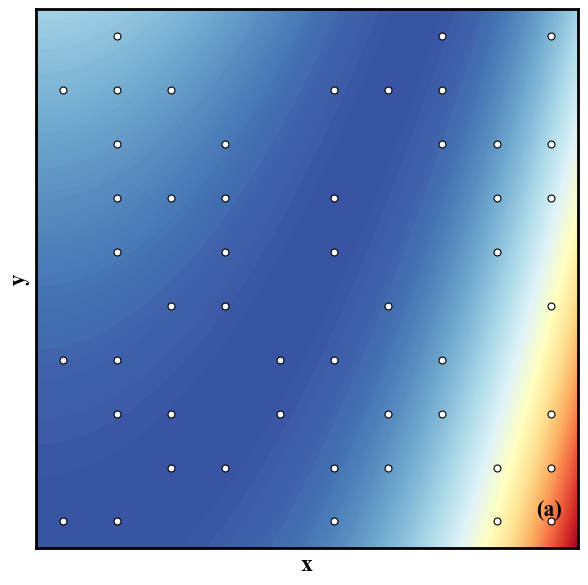

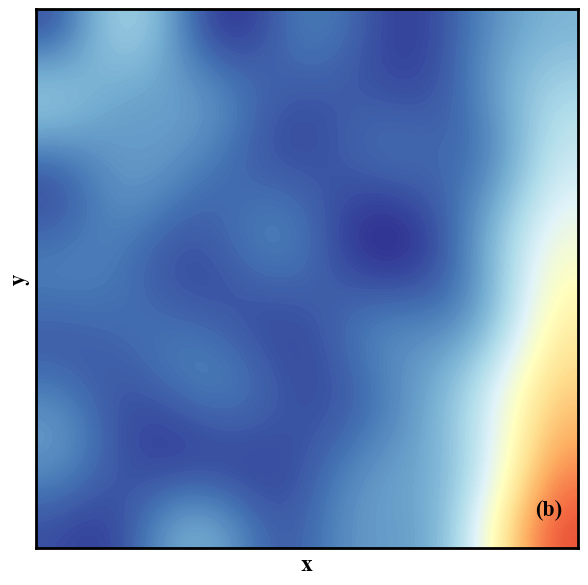

In [6]:
# ----------- Fit NDCT Model and Visualize Results -----------

t = 7
Kx, Ky = t, t
# Fit NDCT model with light Tikhonov regularization (λ = 1e-6)
coeffs = ndct2_fit(x_scaled, y_scaled, z_samples, Kx, Ky, lam=1e-6)

# Generate a dense evaluation grid
Xg, Yg = np.meshgrid(np.linspace(0, 2, 200), np.linspace(0, 2, 200))
Xg_scaled = Xg / 2
Yg_scaled = Yg / 2
# Predict function values on the grid using NDCT coefficients
Zhat = ndct2_predict(Xg_scaled, Yg_scaled, coeffs)

# Compute true Rosenbrock surface for comparison
Ztrue = (1 - Xg)**2 + 100 * (Yg - Xg**2)**2

# Shared color scale for consistent visual comparison
vmin = min(Ztrue.min(), Zhat.min())
vmax = max(Ztrue.max(), Zhat.max())

# ----------- Figure (a): True Rosenbrock Surface -----------
fig, ax = plt.subplots(figsize=(7, 7))
cs0 = ax.contourf(
    Xg, Yg, Ztrue,
    levels=200, cmap="RdYlBu_r",
    antialiased=False, linewidths=0,
    vmin=vmin, vmax=vmax
)

# Plot sampled data points
ax.scatter(
    x_samples, y_samples,
    facecolors='white', edgecolors='black',
    s=25, linewidths=0.8, marker='o'
)

# Axis labels and annotation
ax.set_xlabel('x', fontweight="bold", fontsize=17)
ax.set_ylabel('y', fontweight="bold", fontsize=16)
ax.text(0.97, 0.09, "(a)", transform=ax.transAxes,
        fontsize=16, fontweight="bold", ha="right", va="top")

# Remove ticks and tick labels for clean figure aesthetics
ax.set_xticks([]); ax.set_yticks([])
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

# Thicken border lines
for spine in ax.spines.values():
    spine.set_linewidth(2)


# ----------- Figure (b): NDCT-Predicted Surface -----------
fig, ax = plt.subplots(figsize=(7, 7))
cs1 = ax.contourf(
    Xg, Yg, Zhat,
    levels=200, cmap="RdYlBu_r",
    antialiased=False, linewidths=0,
    vmin=vmin, vmax=vmax
)

# Axis labels and annotation
ax.set_xlabel('x', fontweight="bold", fontsize=17)
ax.set_ylabel('y', fontweight="bold", fontsize=16)
ax.text(0.97, 0.09, "(b)", transform=ax.transAxes,
        fontsize=16, fontweight="bold", ha="right", va="top")

# Remove ticks and tick labels for clean figure aesthetics
ax.set_xticks([]); ax.set_yticks([])
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

# Thicken border lines
for spine in ax.spines.values():
    spine.set_linewidth(2)



In [7]:
def ndct2_objective(Xin):
    """
    Evaluate the NDCT-based surrogate function for optimization (e.g., PSO).

    Parameters
    ----------
    Xin : array_like
        Shape (2,) for a single point [x, y], or (pop, 2) for a batch of points.
        The domain is [0, 2]^2. Internally, coordinates are normalized to [0, 1].

    Returns
    -------
    float or ndarray
        Predicted function value(s) from the NDCT model.
        (Optionally, you can negate this value if using it as a maximization objective.)

    Notes
    -----
    This function uses precomputed NDCT coefficients `coeffs` to predict Z values:
        Zhat(x, y) = Σ_i Σ_j c[i,j] * cos(π*i*x/2) * cos(π*j*y/2)
    """

    A = np.asarray(Xin, dtype=float)
    Kx, Ky = coeffs.shape[0] - 1, coeffs.shape[1] - 1
    i = np.arange(Kx + 1)
    j = np.arange(Ky + 1)

    # ----- Single-point evaluation -----
    if A.ndim == 1:
        x, y = A
        xs, ys = x / 2.0, y / 2.0
        cx = np.cos(np.pi * xs * i)              # (Kx+1,)
        cy = np.cos(np.pi * ys * j)              # (Ky+1,)
        z = cx @ coeffs @ cy                     # Scalar prediction
        return float(z)                          # Return scalar value

    # ----- Batch evaluation -----
    else:
        X = A[:, 0]
        Y = A[:, 1]
        xs, ys = X / 2.0, Y / 2.0
        Cx = np.cos(np.pi * xs[:, None] * i[None, :])  # (pop, Kx+1)
        Cy = np.cos(np.pi * ys[:, None] * j[None, :])  # (pop, Ky+1)
        R = Cy @ coeffs.T                              # (pop, Kx+1)
        z = np.sum(Cx * R, axis=1)                     # (pop,)
        return z                                       # Vector of predictions


In [8]:
# --- Run 2D Modified PSO ---
from pso_new import PSO_new

pso2 = PSO_new(
    func=ndct2_objective, n_dim=2, pop=30, max_iter=151,
    lb=[0.0, 0.0], ub=[2.0, 2.0],
    w_min=0.4, w_max=0.9,               # dynamic inertia
    beta_center=0.3, sigma_pert=0.01, anneal_pert=True,  # velocity annealing
    de_interval=10, de_rate=0.25, de_F=0.5, de_CR=0.9,   # DE hybridization
    verbose=False
)
pso2.record_mode = True
best_xy, best_neg = pso2.run(precision=1e-6, N=20, stop_mode="fitness")
best_val = -float(best_neg)
print("best (x,y):", np.round(best_xy, 6))

best (x,y): [1.287184 1.152486]


C:\Users\16941\AppData\Local\Temp\ipykernel_41148\2468311249.py:21: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x0000020708B99550>' will be ignored
  c.set_rasterized(True)


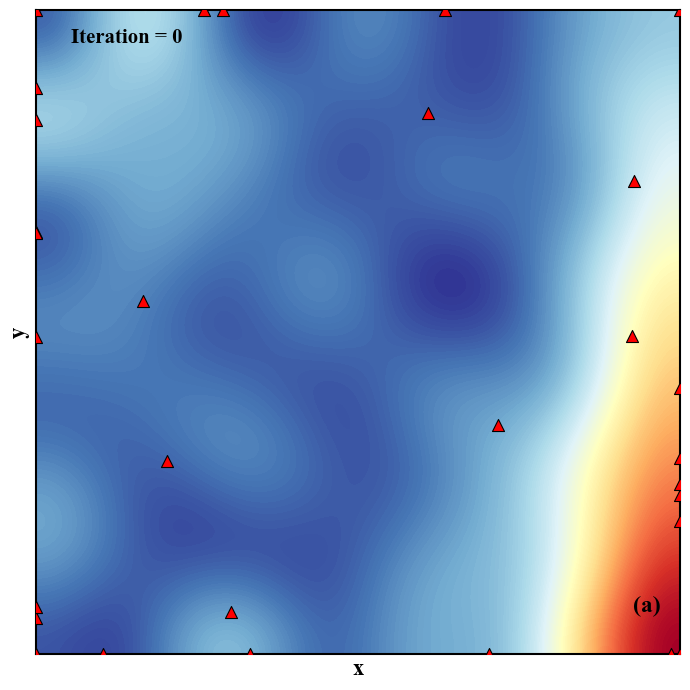

C:\Users\16941\AppData\Local\Temp\ipykernel_41148\2468311249.py:21: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x000002070A511B80>' will be ignored
  c.set_rasterized(True)


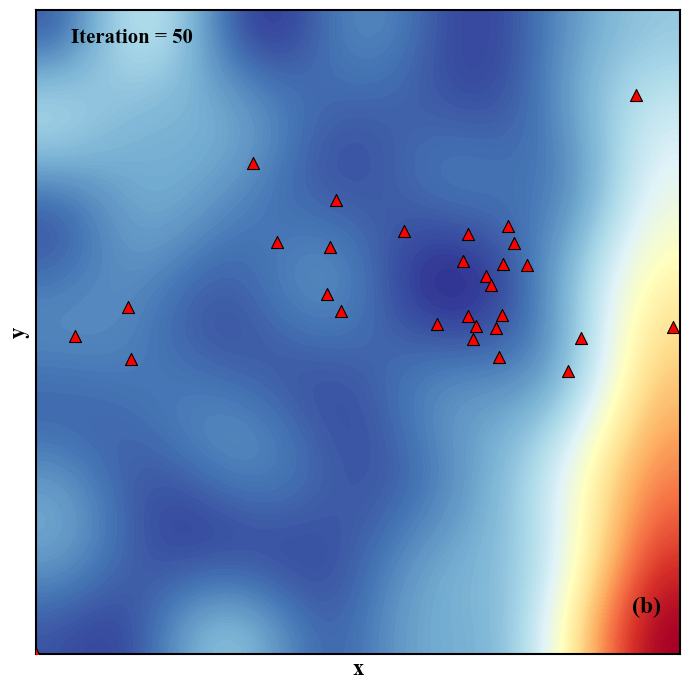

C:\Users\16941\AppData\Local\Temp\ipykernel_41148\2468311249.py:21: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x000002070A4B3E20>' will be ignored
  c.set_rasterized(True)


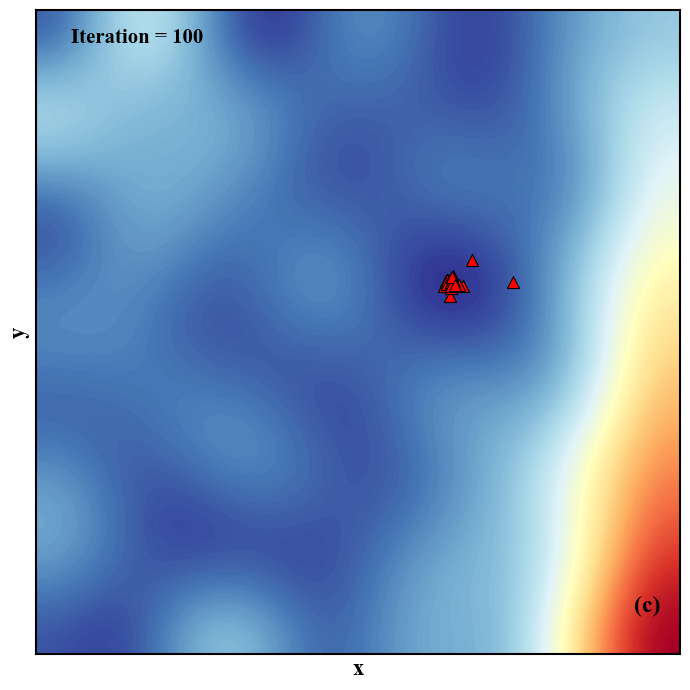

C:\Users\16941\AppData\Local\Temp\ipykernel_41148\2468311249.py:21: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x000002070A56C6D0>' will be ignored
  c.set_rasterized(True)


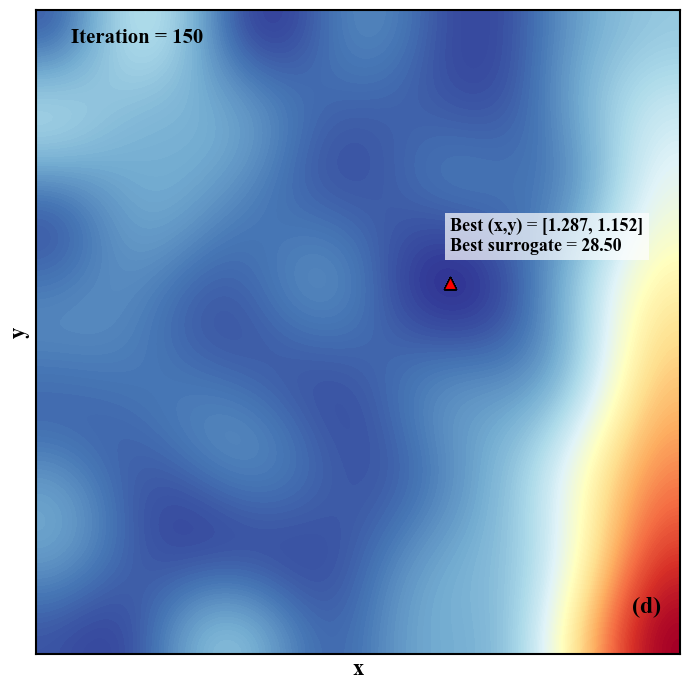

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

target_iters = [0, 50, 100, 150]
panel_tags = ["(a)", "(b)", "(c)", "(d)"]


pso_ref = pso2 if 'pso2' in globals() else pso


best_x, best_y = 1.287184, 1.152486
best_val = 28.50137382185582

for idx, target_iter in enumerate(target_iters):
    fig, ax = plt.subplots(figsize=(7,7))

    
    ax.contourf(Xg, Yg, Zhat, levels=200, cmap="RdYlBu_r")
    for c in ax.collections:
        c.set_rasterized(True)

    
    ax.set_xlabel('x', fontweight="bold", fontsize=16)
    ax.set_ylabel('y', fontweight="bold", fontsize=16)
    ax.text(0.97, 0.09, panel_tags[idx], transform=ax.transAxes,
            fontsize=17, fontweight="bold", ha="right", va="top")

    
    idx_snapshot = max(0, min(target_iter - 1, len(pso_ref.record_value['X']) - 1))
    P = pso_ref.record_value['X'][idx_snapshot]  # shape (pop, 2)

    ax.scatter(
        P[:, 0], P[:, 1],
        c="red", s=75, marker="^", edgecolors="black", linewidths=0.8,
        label=f"PSO Particles (Iter={target_iter})",
        zorder=3
    )

    
    if target_iter == 150:  
        
        ax.text(best_x, best_y+0.1,
                f"Best (x,y) = [{best_x:.3f}, {best_y:.3f}]\nBest surrogate = {best_val:.2f}",
                fontsize=13, fontweight="bold", color="black",
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

    
    ax.set_xticks([]); ax.set_yticks([])
    ax.tick_params(axis='both', which='both', length=0,
                   labelbottom=False, labelleft=False)
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)


    text_only = Line2D([], [], linestyle='None', label=f"Iteration = {target_iter}")
    ax.legend(handles=[text_only], loc='upper left', fontsize=15,
              frameon=False, handlelength=0)

    save_path = fr"D:\lib\gali\Manuscript\figS2\{panel_tags[idx][1]}.svg"
    plt.tight_layout()
    plt.savefig(save_path, format="svg", dpi=600, bbox_inches='tight')
    plt.show()
